### Machine Learning Algorithm for Inferring Behavior From Text Message Data

---

In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pymc as pm
from scipy import stats
import statsmodels.formula.api as smf
from rdrobust import rdrobust,rdbwselect,rdplot

plt.style.use('seaborn-darkgrid')

In this work, I demonstrated the OLS model to recognize changes in behavior from the text-message dataset forked from Cameron Davidson-Pilon GitHub repository on: https://github.com/aprds/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers.

I compared his work on Bayesian inferential to my work using the OLS model known as regression discontinuity (RD). Both methods have a different approach but can be utilized to recognize behavior changes in the text message dataset.

---
#### Loading & Ploting Dataset
---

In [3]:
ms = pd.read_excel('data/txtdata.xlsx')
ms.head()

,time,msg_received
0,0,13
1,1,24
2,2,8
3,3,24
4,4,7


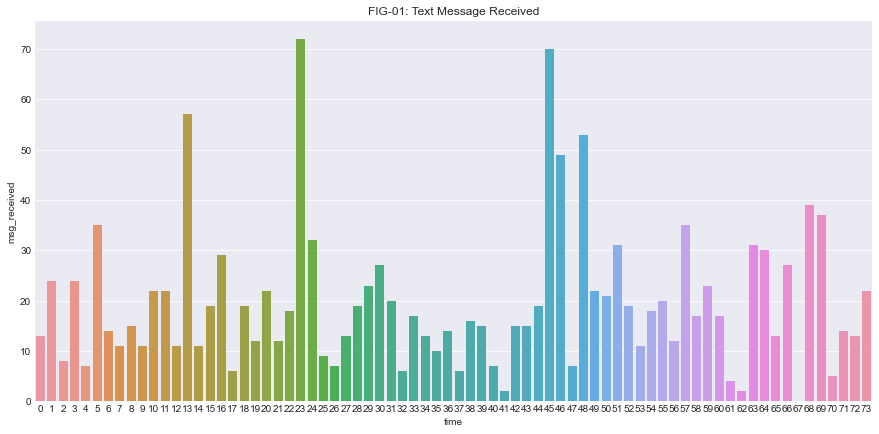

In [4]:
fig, ax = plt.subplots(figsize=(15,7))

sns.barplot(x='time', y='msg_received', data=ms, ax=ax)
plt.title('FIG-01: Text Message Received');

As shown on the `FIG-01`, the text messages received were fluctuating from the beginning to the end. To our eyes, as humans,  this fluctuation reflects the messaging behavior, and it seems random. When someone asked us: "Have you encountered some behavior changes in messaging?" To answer this question, We can make any guesses, subjectively, of course, to say that YES, I DO! the changing in behavior happened after day 17, but some say after day 40, others say after day 44, and guessing continue endlessly.

---
#### Regression Discontinuity (RD) Function
---

To solve this problem by using `Ordinary Least Square - Regression Discontinuity (OLS-RD)`, I generated a function `(rd_inference)` that would do sequential calculation involving data manipulation and feature engineering. Moreover, The function would activate `statsmodels - OLS` along with a formula that I arranged to represent RD and returned a NumPy array consisting of time, threshold, rate/ slope, and p-value of threshold & rate/ slope.

**_Variable explanation:_**
> * `data` : text message dataset
> * `disc_after` : (time index at discontinuity - 1), informing an index (time) right before the beginning of discontinuity
> * `time_id` : numpy array of time
> * `thresh_id` : numpy array of % threshold (coef.)
> * `rate_id` : numpy array of rate/ slope of trending text message data after discontinuity period relative to initial (before discontinuity period)
> * `pv_thresh` : numpy array of p-value for each % threshold (coef.)
> * `pv_rate` : numpy array of p-value for each rate/ slope (coef.) after discontinuity
> * `mod_ols` : dict of model results collection for each time of iteratrions start on `disc_after`
> * `df_mod_ms`: transforming selected function results `res` to become a dataframe consists of essential variable in `time_id`, `thresh_id`, `rate_id`, `pv_thresh`, and `pv_rate`

**_Feature Engineering:_**
> * `rel_time`: a variable represents time relative to `disc_after`. It gave zero value at `disc_after`, negative and positive values before & after `disc_after` respectively. It marked a period after discontinuity by positive value and negative on the opposite and `disc_after` as separator
> * `threshold`: to fulfill the equation needs in separating that timeline, I set a feature based on `rel_time` with the same purpose where It marked a period after discontinuity by 1 and 0 on the opposite until `disc_after.`



**_Numerical:_**
> I specifically applied the robust `covariance type HC3`, hoping to tackle some heteroscedastic problems that might occur during iteration and modeling.


**_Formulation:_**
> I used the `statsmodels` package and configured its syntax using a formula to obtain OLS-RD. As shown below, the formula was inserted as simple as <"msg_received ~ rel_time*threshold">. Using this formula, I could obtain a series of results that are very useful for conducting a full analysis and drawing a meaningful conclusion regarding text message behavior by using OLS-RD. Those results are a bunch of parameters from OLS, for example, thresh_id, time_id, rate_id, pv_thresh, and pv_rate.


In [5]:
def rd_inference(data, disc_after):

    time_id = np.zeros(len(data.index))
    thresh_id = np.zeros(len(data.index))
    rate_id = np.zeros(len(data.index))
    pv_thresh = np.zeros(len(data.index))
    pv_rate = np.zeros(len(data.index))
    mod_ols = {}

    for i in range(disc_after, len(data.index)-disc_after, 1):

        data['rel_time'] = data.apply(lambda row: row['time']-i, axis=1)
        data['threshold'] = data.apply(lambda row: 1 if row['rel_time'] > 0 else 0, axis=1)

        mod_ols[i] = smf.ols("msg_received ~ rel_time*threshold", data).fit(cov_type='HC3')
        
        time_id[i+1] = i+1
        thresh_id[i+1] = mod_ols[i].params[2]
        rate_id[i+1] = mod_ols[i].params[3]
        pv_thresh[i+1] = mod_ols[i].pvalues[2]
        pv_rate[i+1] = mod_ols[i].pvalues[3]
    
    X = np.column_stack((time_id, thresh_id, rate_id, pv_thresh, pv_rate))

    return X

---
#### Modeling in Action
---

In this section, I used `disc_after` equal to 1, meaning that I started the modeling since day index 1 and made a DataFrame that consisted of an important coefficient related to text message behavior anomaly detection.

In [6]:
disc_after = 1

res = rd_inference(ms, disc_after)
df_mod_ms = pd.DataFrame(res, columns=['time', 'threshold', 'rate', 'pv_treshold', 'pv_rate'])

C:\Users\andip\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\andip\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide


In [7]:
df_mod_ms

,time,threshold,rate,pv_treshold,pv_rate
0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000
2,2.0,-4.967527,-10.979581,0.502440,0.383749
3,3.0,7.188934,2.507076,0.760759,0.895526
4,4.0,-0.355280,-1.687578,0.976322,0.729386
...,...,...,...,...,...
69,69.0,3.653002,-2.237998,0.909391,0.794304
70,70.0,-21.069618,4.942910,0.000113,0.001335
71,71.0,-12.848592,3.963011,0.403350,0.575192
72,72.0,-16.826104,8.971252,1.000000,1.000000


---
#### Results & Evaluations
---

**_Bayesian Result:_**

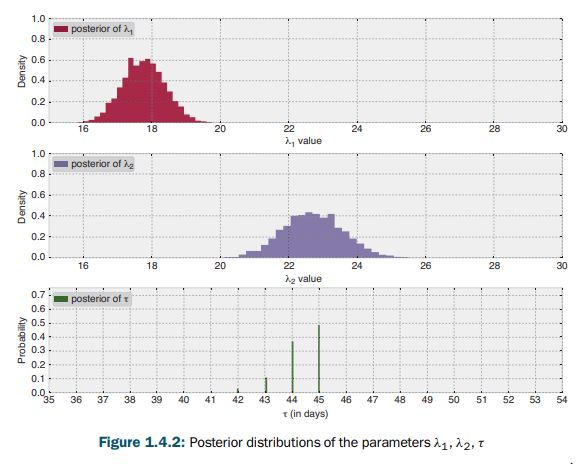

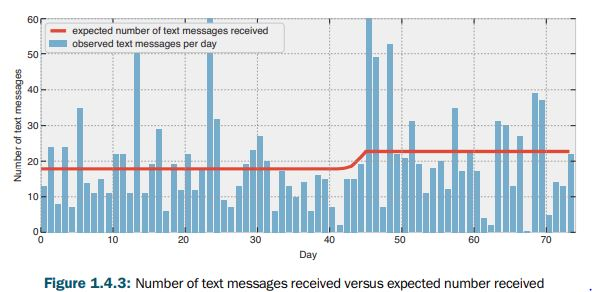

On this part, I uploaded two pictures from Cameron's book. As shown in `Figure 1.4.2`, in the third-row picture, we can infer from the dataset that behavior changes probably occurred on days 42 to 45; those four days had probability values that explained how likely they might happen by using probability terms. As Cameron explained in his book, this result could be obtained using Bayesian Analysis and probabilistic modeling.

Not only do we notice those behavior changes by around 20% (lambda-2/ lambda-1), but we can also conclude that those changes remain until the last day of recorded data by looking at the red line on `Figure 1.4.3` after day 45. This new level of the red line after day 45 represents the new average of daily text messages received, and it's different than early days before 42. The earlier section (before anomaly) is defined as lambda-1, and lambda-2 represents the rest.

Cameron's book source: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

**_OLS Results (OLS-RD):_**

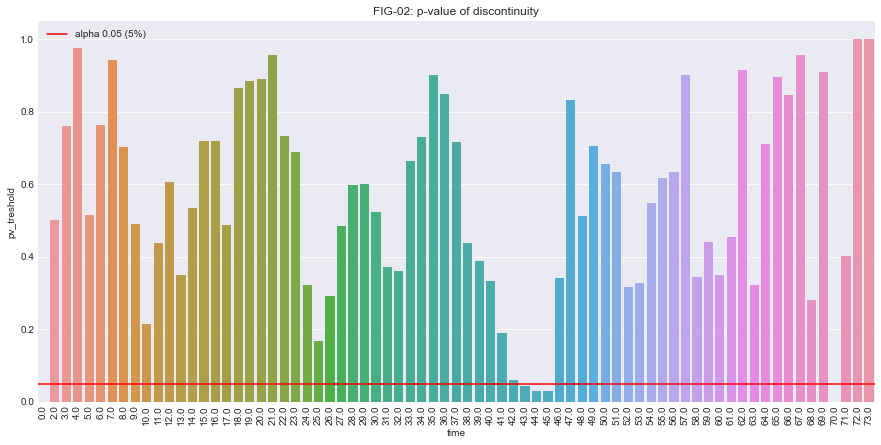

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x='time', y='pv_treshold', data=df_mod_ms, ax=ax)
ax.axhline(0.05, c='r', label='alpha 0.05 (5%)')
ax.tick_params(axis='x', rotation=90)
plt.title('FIG-02: p-value of discontinuity')
ax.legend(loc=2);

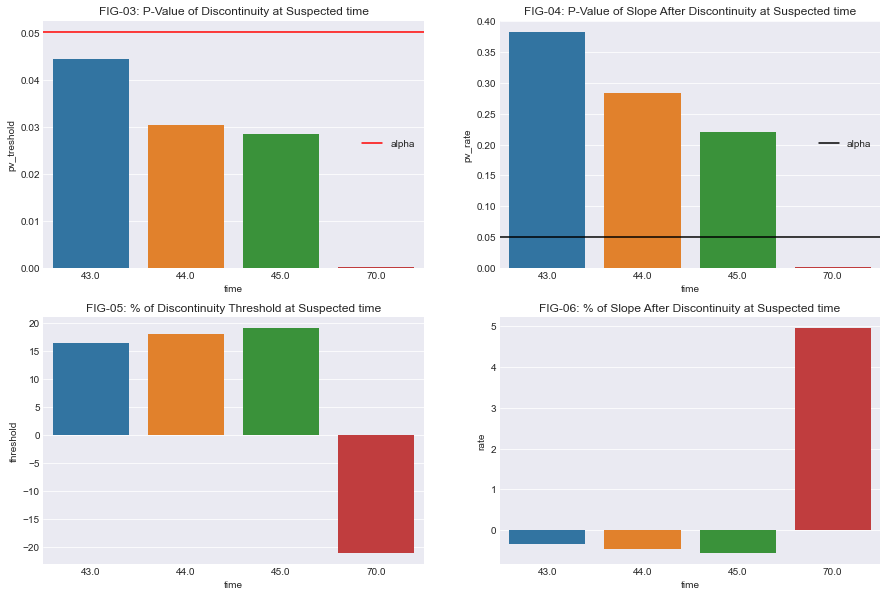

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

filter = df_mod_ms.apply(lambda row : 1 if (row['threshold']+row['rate']+row['pv_treshold']+row['pv_rate']) !=0 else 0, axis=1)

sns.barplot(x='time', y='pv_treshold', data=df_mod_ms[(df_mod_ms.pv_treshold < 0.05) & (filter != 0)], ax=ax[0,0])
sns.barplot(x='time', y='pv_rate', data=df_mod_ms[(df_mod_ms.pv_treshold < 0.05) & (filter != 0)], ax=ax[0,1])
sns.barplot(x='time', y='threshold', data=df_mod_ms[(df_mod_ms.pv_treshold < 0.05) & (filter != 0) ], ax=ax[1,0])
sns.barplot(x='time', y='rate', data=df_mod_ms[(df_mod_ms.pv_treshold < 0.05) & (filter != 0)], ax=ax[1,1])

ax[0,0].axhline(0.05, c='r', label='alpha')
ax[0,1].axhline(0.05, c='k', label='alpha')

ax[0,0].set_title('FIG-03: P-Value of Discontinuity at Suspected time')
ax[0,1].set_title('FIG-04: P-Value of Slope After Discontinuity at Suspected time')
ax[1,0].set_title('FIG-05: % of Discontinuity Threshold at Suspected time')
ax[1,1].set_title('FIG-06: % of Slope After Discontinuity at Suspected time')

ax[0,0].legend(loc=5)
ax[0,1].legend(loc=5);

Since I did my work using the frequentist method, we were expecting that the result would not appear to be probabilistic but deterministic, judging by its p-value to decide whether this value was statistically significant or not. I used the p-value threshold as alpha by magnitude 0.05 (5%) to determine when the behavior changes occurred at a particular time.

By looking at `FIG-03`, We notice that a series of times have a p-value below the threshold of 5%, and it occurs in the day: 43, 44, 45, and 70. It explains that some behavior changes might occur on any of these days judging by its statistically significant level. We cannot decide with certainty which one of those days is the correct one. It is a surprise that these frequentist results overlap with the Bayesian model and only deviate on the last day when the Bayesian model says no changes on day 70 but not to frequentist.

Having done threshold analysis in indexing when behavior changes occurred on a particular day, we could further decide whether a trend might also exist after the threshold. These trends were vital since they allowed us to understand the behavior in text messaging on the period after threshold, whether an inclined followed after by decline. By looking at `FIG-06`, we notice that after suspected days on day 43 or 44 or 45 and after 70, 2 trend exists but have a different direction. Day 43-45 has a declining trend after each threshold with a small trending/ slope magnitude (below 1%) and a relatively strong trend on day 70 with a magnitude around 5%. That information would lead someone to error if the conclusion were inferred just from trend magnitude alone without observing its p-value as representation using statistical power. When we look at those p-values on `FIG-04` for days 43-45, none of them has a significant value below 5%. Hence we could assume, statistically, of course, that those trend existence are absent, or we are allowed to conclude that after some threshold, those new level of text messaging behavior remains intact until day 70 without trending (up or down). These results are similar to the bayesian method, judging by its level of text messaging after behavior changes that the new average level (red line on `Figure 1.4.5` remained constant until the end).

Comparing these 2 model results, we can conclude that the two methods might work on specific problems and give a similar outcome if we have to obtain the percentage of behavior changes on text messages during suspected day inferred by its p-value so we could use `FIG-05` and observe its percentage on those supposed days (43, 44, 45, and 70). On suspected days 43, 44, and 45, the results show some similarity to the Bayesian method that the changes occur around 15-20% increased from the usual or initial period, and for day 70, only the frequentist method could do inferential analysis that behavior changes also occur but with a different direction than early suspected days (43, 44, and 45).

**_Evaluation:_**

Although both methods have similar capabilities, they deviate from approaching the problem. Using the frequentist method that I demonstrated, I could draw some conclusions that this method is fast and requires minimal computational cost compared to Bayesian. Suppose the cost is not a significant problem. In that case, we could proceed with the Bayesian approach to obtain more rigorous results, for instance, how likely (in terms of probability) an event would occur. Another limitation might prevail when using the frequentist method because it is susceptible to data quality and quantity, and if this setback is involved so, we have to conduct a more thorough analysis beforehand or to decide with the Bayesian method directly.